In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
            i += 1
        return df

In [7]:
df = read_csv_replace_missing_by_polynomial('pib_rio_de_janeiro.csv', 0, 0)
df.head(len(df))

,Ano,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado
0,1985,1.116928e+08,1.818706e+07,21.579869,3.016289e+08
1,1986,1.262856e+08,1.850155e+07,21.662038,3.063299e+08
2,1987,1.424441e+08,1.868951e+07,21.737415,3.109389e+08
3,1988,1.599306e+08,1.895329e+07,21.844437,3.159100e+08
4,1989,1.783775e+08,1.925512e+07,21.957861,3.208777e+08
5,1990,1.976888e+08,1.939168e+07,22.063268,3.254565e+08
6,1991,2.156371e+08,1.961300e+07,22.109310,3.288002e+08
7,1992,2.325785e+08,1.974396e+07,22.081830,3.308077e+08
8,1993,2.496516e+08,1.969818e+07,22.074993,3.329281e+08
9,1994,2.681449e+08,1.957150e+07,22.100936,3.355933e+08


In [8]:
df_year = df.copy()
df_year.set_index('Ano', inplace=True)
df_year

,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado
Ano,,,,
1985,1.116928e+08,1.818706e+07,21.579869,3.016289e+08
1986,1.262856e+08,1.850155e+07,21.662038,3.063299e+08
1987,1.424441e+08,1.868951e+07,21.737415,3.109389e+08
1988,1.599306e+08,1.895329e+07,21.844437,3.159100e+08
1989,1.783775e+08,1.925512e+07,21.957861,3.208777e+08
1990,1.976888e+08,1.939168e+07,22.063268,3.254565e+08
1991,2.156371e+08,1.961300e+07,22.109310,3.288002e+08
1992,2.325785e+08,1.974396e+07,22.081830,3.308077e+08
1993,2.496516e+08,1.969818e+07,22.074993,3.329281e+08


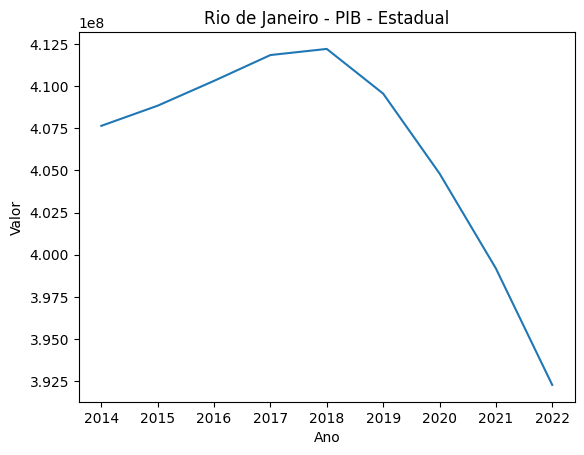

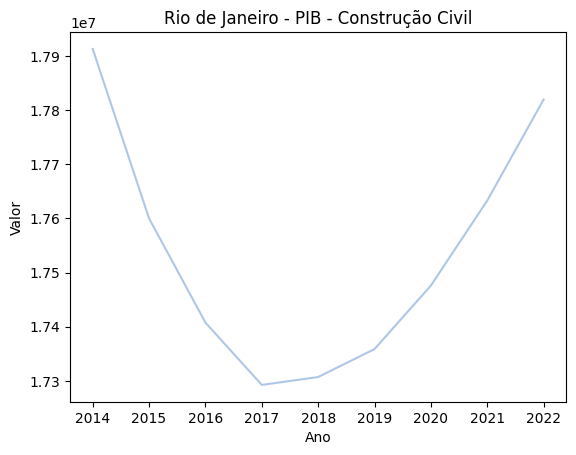

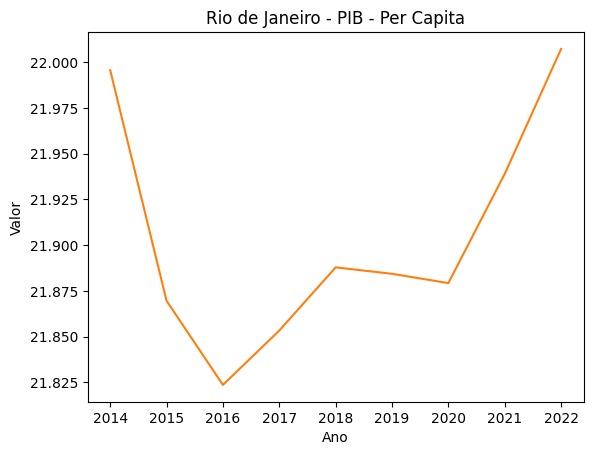

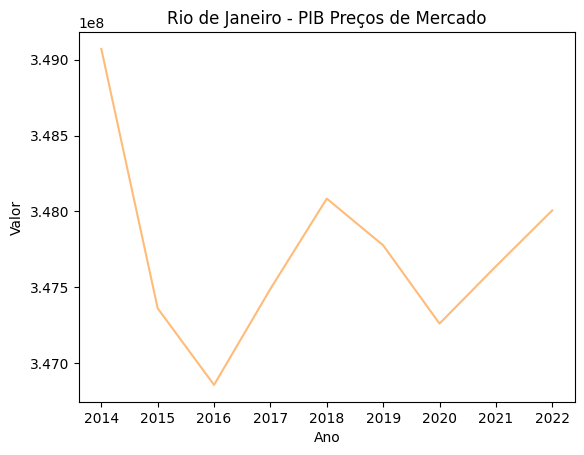

,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado
Ano,,,,
2014,4.076404e+08,1.791300e+07,21.995673,3.490706e+08
2015,4.088358e+08,1.760007e+07,21.869610,3.473618e+08
2016,4.103079e+08,1.740778e+07,21.823613,3.468569e+08
2017,4.118381e+08,1.729266e+07,21.853351,3.474898e+08
2018,4.122014e+08,1.730724e+07,21.887873,3.480844e+08
2019,4.095523e+08,1.735883e+07,21.884365,3.477769e+08
2020,4.048172e+08,1.747607e+07,21.879279,3.472610e+08
2021,3.991874e+08,1.763301e+07,21.939011,3.476382e+08
2022,3.922773e+08,1.781952e+07,22.007300,3.480068e+08


In [9]:
df_2014 = df_year[df_year.index >= 2014]
plot_columns(df_2014)
df_2014

In [10]:
df_2014.to_csv('2014_01_pib.csv')

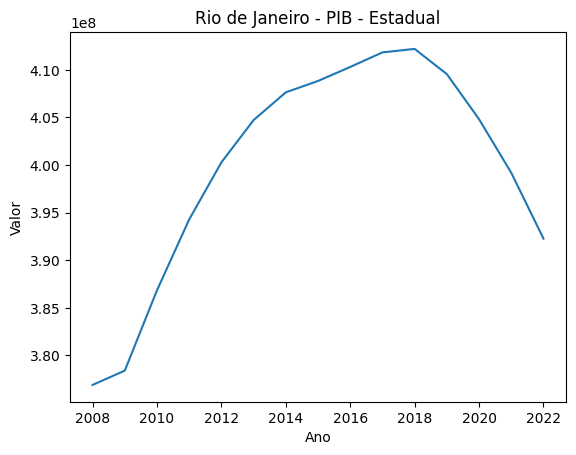

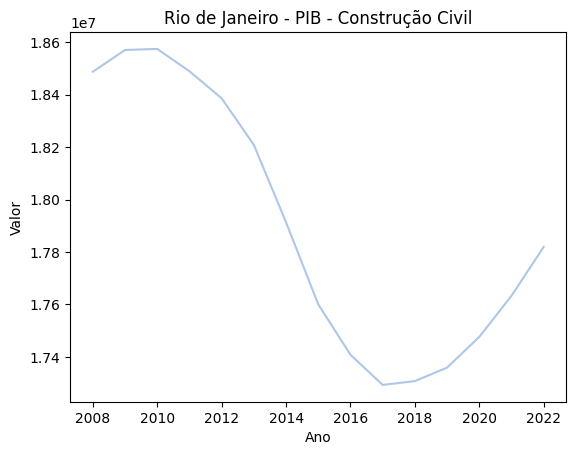

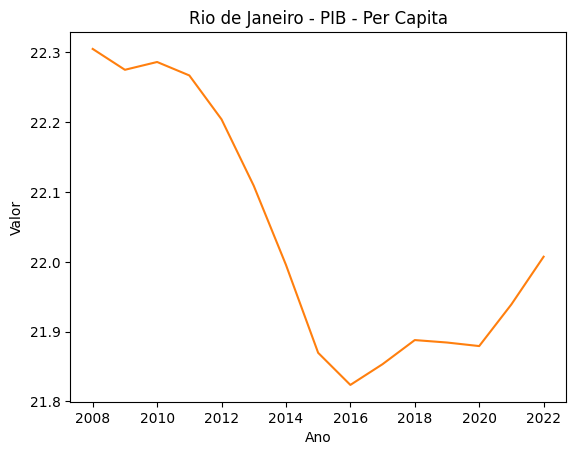

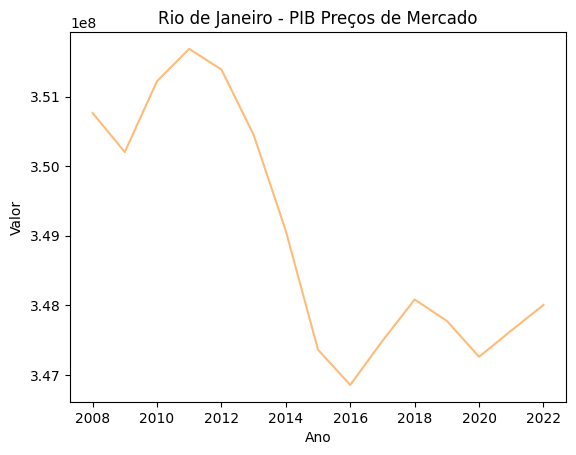

,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado
Ano,,,,
2008,3.769087e+08,1.848763e+07,22.305022,3.507645e+08
2009,3.784121e+08,1.857076e+07,22.275112,3.502037e+08
2010,3.868458e+08,1.857479e+07,22.286297,3.512210e+08
2011,3.942901e+08,1.848968e+07,22.267033,3.516849e+08
2012,4.002860e+08,1.838631e+07,22.204155,3.513894e+08
2013,4.047278e+08,1.820862e+07,22.108996,3.504515e+08
2014,4.076404e+08,1.791300e+07,21.995673,3.490706e+08
2015,4.088358e+08,1.760007e+07,21.869610,3.473618e+08
2016,4.103079e+08,1.740778e+07,21.823613,3.468569e+08


In [10]:
df_2008 = df_year[df_year.index >= 2008]
plot_columns(df_2008)
df_2008

In [11]:
df_2008.to_csv('2008_01_pib.csv')